In [1]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
from nxcals.api.extraction.data.builders import *

Matplotlib is building the font cache; this may take a moment.


In [2]:
with open('rfko_gain_dataframe.pickle', 'rb') as f:
    gain_df = pickle.load(f)

In [3]:
start = str(gain_df.timestamp.min())
end = str(gain_df.timestamp.max())

In [368]:
df_xsec_70_spill = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/SpillData").build().toPandas()
# Convert acqStamp to timestamp
selectors_to_keep = ['CPS.USER.EAST4', 'CPS.USER.EAST3', 'CPS.USER.MD5']
df_xsec_70_spill = df_xsec_70_spill[df_xsec_70_spill['selector'].isin(selectors_to_keep)]
df_xsec_70_spill = df_xsec_70_spill.dropna()
df_xsec_70_spill["timestamp"] = df_xsec_70_spill["acqStamp"]/1000000000
df_xsec_70_spill["timestamp"] = [datetime.fromtimestamp(x) for x in df_xsec_70_spill["timestamp"]]
df_xsec_70_spill.sort_values(by=['timestamp'], inplace=True)
spill_time=0.36 # length of a spill in seconds
df_xsec_70_spill['intensity'] = df_xsec_70_spill.semSpillData.apply(lambda x: -x["elements"].sum()/spill_time)
df_xsec_70_spill = df_xsec_70_spill.drop(["__record_timestamp__","__record_version__","acqStamp","class","cyclestamp","semSpillData","nxcals_entity_id"], axis=1)
df_xsec_70_spill.head(3)

# Merge with the gain dataframe
df_xsec70 = pd.merge_asof(df_xsec_70_spill.sort_values('timestamp'), gain_df.sort_values('timestamp'), on='timestamp', direction='nearest')

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [369]:
# slope_intercept_dict = {
#     'CPS.USER.EAST4': (125.0, 0.0),
#     'CPS.USER.EAST3': (78.5, 398.6),
#     'CPS.USER.MD5': (34.4, 58.4)
# }

GAIN = 400

# define a custom function to apply different multipliers based on 'selector'
def apply_multiplier(row):
    if row['selector'] == 'CPS.USER.EAST3':
        return row['intensity'] * 125/GAIN + 0.0
    elif row['selector'] == 'CPS.USER.EAST4':
        return row['intensity'] * 78.5/GAIN + 398.6
    elif row['selector'] == 'CPS.USER.MD5':
        return row['intensity'] * 34.3/GAIN + 58.4
    else:
        return row['intensity']   # default to no change

# create a new column by applying the custom function to each row of the dataframe
df_xsec_70_spill['flux'] = df_xsec_70_spill.apply(apply_multiplier, axis=1)

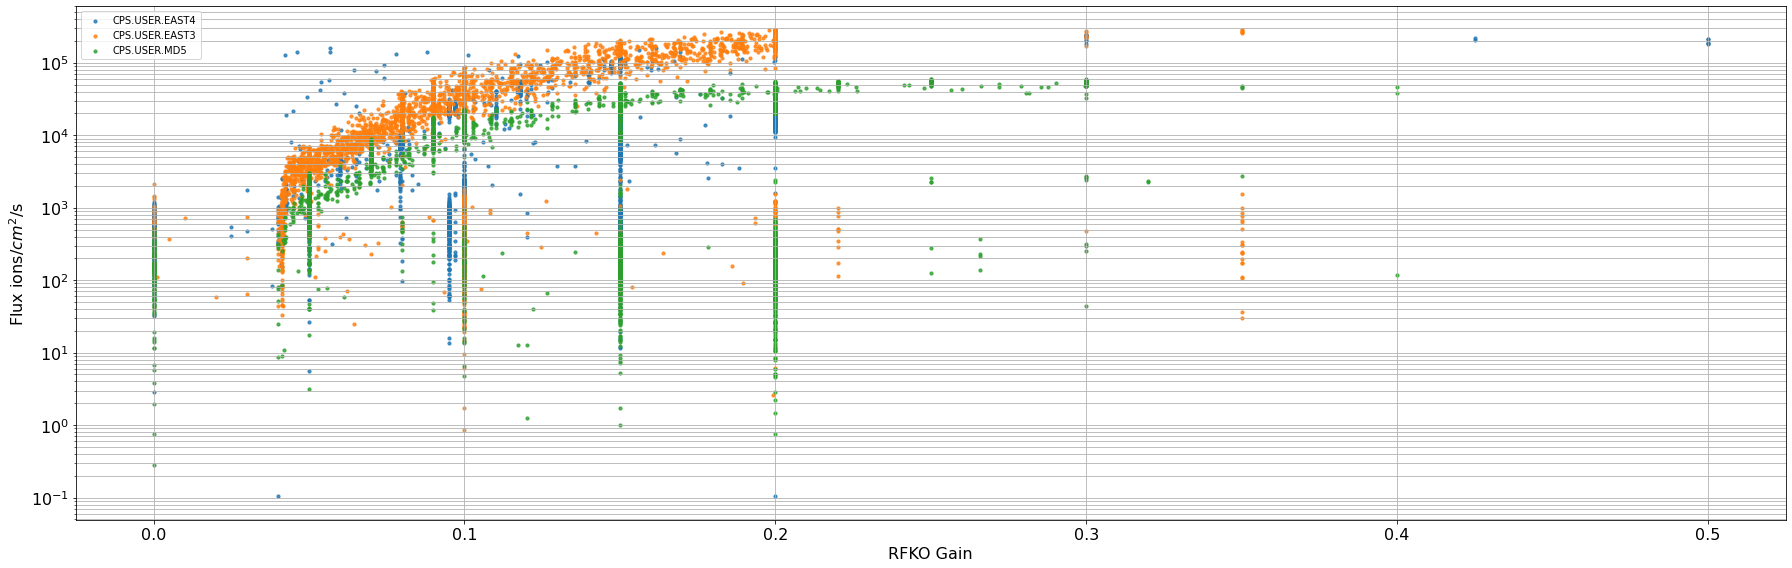

In [370]:
df_xsec70 = pd.merge_asof(df_xsec_70_spill.sort_values('timestamp'), gain_df.sort_values('timestamp'), on='timestamp', direction='nearest')

fig, ax = plt.subplots(tight_layout=True, figsize=(25,8))

for selector in ['CPS.USER.EAST4', 'CPS.USER.EAST3', 'CPS.USER.MD5']:

    ax.scatter(df_xsec70.where(df_xsec70.selector == selector).gain, df_xsec70.where(df_xsec70.selector == selector).flux, s=10, alpha=0.8, label=f"{selector}")
    
ax.legend()
ax.set_yscale("log")
# ax.set_xlim(0.03,0.22)
# ax.set_ylim(1e2,1e6)

ax.set_xlabel("RFKO Gain", fontsize=16)
ax.set_ylabel("Flux ions/$cm^{2}$/s", fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(which='both', axis='both')

In [371]:
# Replace all the lines with the same gain value in the DataFrame df_xsec70 and replace the intensity values with the median of the intensities associated with that gain value, you can use the groupby method in pandas.

# group the data by gain and calculate the median intensity for each group
df_median = df_xsec70.groupby('gain')['intensity'].median().reset_index()

# merge the median intensity values with the original DataFrame based on gain
df_xsec70 = pd.merge(df_xsec70.drop('intensity', axis=1), df_median, on='gain')

# drop duplicate rows based on gain
df_xsec70 = df_xsec70.drop_duplicates(subset='gain')

# reset the index of the DataFrame
df_xsec70 = df_xsec70.reset_index(drop=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Smoothed Function of y as a Function of x')

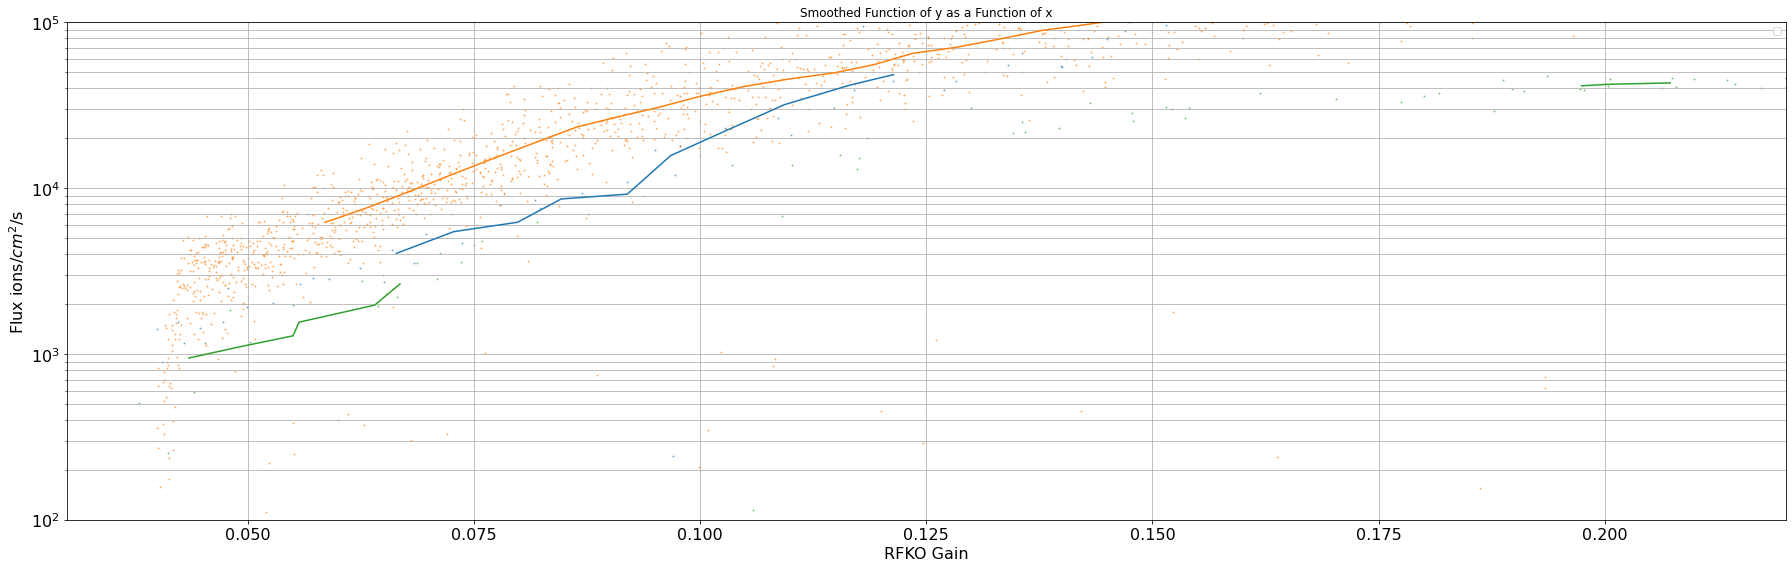

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fig, ax = plt.subplots(tight_layout=True, figsize=(25,8))
for selector in ['CPS.USER.EAST4', 'CPS.USER.EAST3', 'CPS.USER.MD5']:
    
    x = df_xsec70.where(df_xsec70.selector == selector).gain.dropna()
    y = df_xsec70.where(df_xsec70.selector == selector).flux.dropna()
    
    # create a binning function
    def bin_data(x, y, nbins):
        bins = np.linspace(x.min(), x.max(), nbins+1)
        idx = np.digitize(x, bins)
        binned_x = np.array([x[idx==i].mean() for i in range(1, nbins+1)])
        binned_y = np.array([y[idx==i].mean() for i in range(1, nbins+1)])
        return binned_x, binned_y

    # bin the data into 100 bins
    nbins = 75
    binned_x, binned_y = bin_data(x, y, nbins)

    # smooth the binned data using a Savitzky-Golay filter
    window_size = 9
    poly_order = 3
    smooth_y = savgol_filter(binned_y, window_size, poly_order)

    # plot the smoothed data
    ax.plot(binned_x, smooth_y)
    ax.scatter(x, y, s=1, alpha=0.5)
    
ax.legend()
ax.set_yscale("log")
ax.set_xlim(0.03,0.22)
ax.set_ylim(1e2,1e5)
ax.set_xlabel("RFKO Gain", fontsize=16)
ax.set_ylabel("Flux ions/$cm^{2}$/s", fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(which='both', axis='both')
ax.set_title('Smoothed Function of y as a Function of x')

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


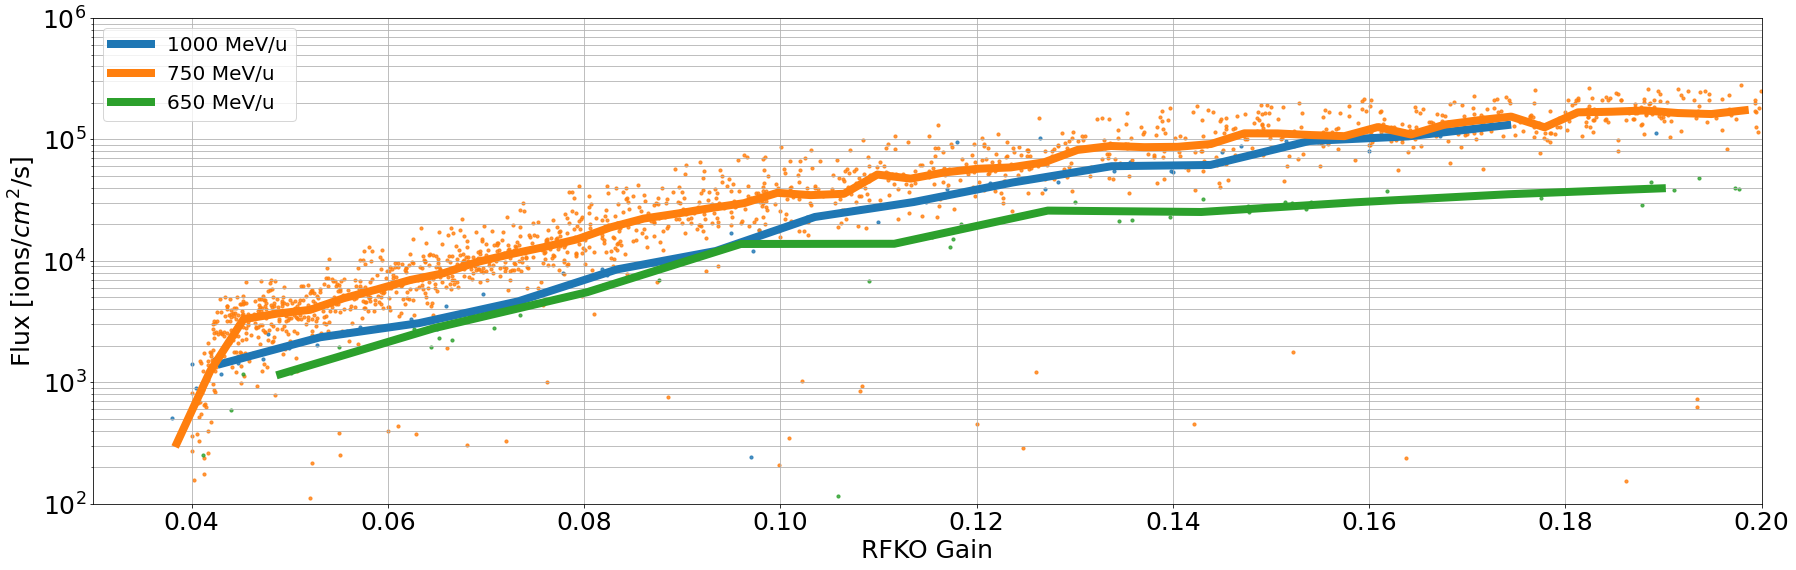

In [378]:
fig, ax = plt.subplots(tight_layout=True, figsize=(25,8))
for selector in ['CPS.USER.EAST4', 'CPS.USER.EAST3', 'CPS.USER.MD5']:
    # filter the data by selector and x value limits using boolean indexing
    mask = (df_xsec70['selector'] == selector) & (df_xsec70['gain'] > 0.025) & (df_xsec70['gain'] < 0.2)
    x = df_xsec70.loc[mask, 'gain'].dropna().values
    y = df_xsec70.loc[mask, 'flux'].dropna().values

    # set the number of bins you want to use
    
    if selector == 'CPS.USER.EAST4':
        num_bins =15
        label = "1000 MeV/u"
    elif selector == 'CPS.USER.EAST3':
        num_bins = 50
        label = "750 MeV/u"
    elif selector == 'CPS.USER.MD5':
        num_bins = 10
        label = "650 MeV/u"

    # use numpy to calculate the bin edges and the median of y in each bin
    bin_edges = np.linspace(np.min(x), np.max(x), num_bins+1)
    bin_indices = np.digitize(x, bin_edges)
    bin_medians = np.empty(num_bins)
    for i in range(num_bins):
        bin_medians[i] = np.nanmedian(y[bin_indices==i+1])

    # plot the binned data
    ax.scatter(x, y, s=10, alpha=0.8)
    ax.plot((bin_edges[:-1]+bin_edges[1:])/2, bin_medians, lw=8, label=f"{label}")

ax.legend(fontsize=20)
ax.set_yscale("log")
ax.set_xlim(0.03,0.2)
ax.set_ylim(1e2,1e6)
ax.set_xlabel("RFKO Gain", fontsize=25)
ax.set_ylabel("Flux [ions/$cm^{2}$/s]", fontsize=25)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.grid(which='both', axis='both')
plt.savefig("xsec70_flux.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')